# Leveraging Text2SQL use-cases with SQL Agents

## Objective: Zero shot ReACt + SQL

React means [_REasoning_ and _ACTing_](https://arxiv.org/abs/2210.03629) This framework allows LLM to act on the following: tryptic:
* thought
* observation
* action


![ReAct Framework](https://react-lm.github.io/files/diagram.png)

Zero-shot means that no previous examples were fed by the LLM. In our specific case, the environment is an SQL database, more specifically SQLIte databases.

In this notebook, we are going to first use a simple agentic framework connecting as a driver for a SQL engine. Then, we're going to leverage this framework in order to apply a whole chain including Text to SQL.

In [1]:
from langchain import  SQLDatabase #, SQLDatabaseChain
from langchain.llms.bedrock import Bedrock
import boto3

bedrockruntime = boto3.client('bedrock-runtime')


## Titanic Open Table in _sqlite_

First we want to know if our SQL companion is able to perform single table queries. Let's explore a sample _titanic_ table from SQLite database. Link is 

In [3]:
!cd data

In [9]:
!pwd

/root/startup-loft-genai-102


In [15]:
titanicdb = SQLDatabase.from_uri("sqlite:///titanic.db")


In [16]:
from IPython.display import Markdown, display

display(Markdown("````{sql}\n"+titanicdb.get_table_info(['titanic']) + "\n````"))

````{sql}

CREATE TABLE titanic (
	"PassengerId" TEXT, 
	"Survived" TEXT, 
	"Pclass" TEXT, 
	"Name" TEXT, 
	"Sex" TEXT, 
	"Age" TEXT, 
	"SibSp" TEXT, 
	"Parch" TEXT, 
	"Ticket" TEXT, 
	"Fare" TEXT, 
	"Cabin" TEXT, 
	"Embarked" TEXT
)

/*
3 rows from titanic table:
PassengerId	Survived	Pclass	Name	Sex	Age	SibSp	Parch	Ticket	Fare	Cabin	Embarked
1	0	3	Braund, Mr. Owen Harris	male	22	1	0	A/5 21171	7.25	None	S
2	1	1	Cumings, Mrs. John Bradley (Florence Briggs Thayer)	female	38	1	0	PC 17599	71.2833	C85	C
3	1	3	Heikkinen, Miss. Laina	female	26	0	0	STON/O2. 3101282	7.925	None	S
*/
````

We can use the _titanicdb_ object as an execution driver for our SQLIte DB

In [17]:
titanicdb.run('SELECT SUM(Survived) FROM titanic')

'[(342,)]'

Let's use Cohere Command LLM with Bedrock natively integrated within Langchain.

In [18]:

modelId = 'cohere.command-text-v14' #
llm = Bedrock(
    model_id=modelId,
    model_kwargs={
        "p": 1,
        "temperature":0.0,
           "max_tokens":4000
    },
    client=bedrockruntime,
)


from langchain.chains import create_sql_query_chain


In [19]:
titanic_chain = create_sql_query_chain(llm, titanicdb)

Using Cohere command with Bedrock SDK, we can try to outline a SQL query.

In [20]:
import json

prompt = '''
You have below the titanic table description, alongside with 3 displayed rows. Outline a SQL queries to answer the following question: how many passengers survived?


CREATE TABLE titanic (
    "PassengerId" TEXT, 
    "Survived" TEXT, 
    "Pclass" TEXT, 
    "Name" TEXT, 
    "Sex" TEXT, 
    "Age" TEXT, 
    "SibSp" TEXT, 
    "Parch" TEXT, 
    "Ticket" TEXT, 
    "Fare" TEXT, 
    "Cabin" TEXT, 
    "Embarked" TEXT
)

/*
3 rows from titanic table:
PassengerId Survived    Pclass  Name    Sex Age SibSp   Parch   Ticket  Fare    Cabin   Embarked
1   0   3   Braund, Mr. Owen Harris male    22  1   0   A/5 21171   7.25    None    S
2   1   1   Cumings, Mrs. John Bradley (Florence Briggs Thayer) female  38  1   0   PC 17599    71.2833 C85 C
3   1   3   Heikkinen, Miss. Laina  female  26  0   0   STON/O2. 3101282    7.925   None    S
*/'''


body = json.dumps({"prompt":prompt, "temperature":0.0})

In [26]:
from IPython.display import display, Markdown

res = bedrockruntime.invoke_model(body=body, modelId=modelId)


In [27]:
#display(Markdown(res['body'].read().decode('utf8')['text']))

out = res['body'].read().decode('utf8')
display(Markdown(json.loads(out)['generations'][0]['text']))

 To answer how many passengers survived, you can use the following SQL query:
```sql
SELECT COUNT(PassengerId) as SurvivedCount
FROM titanic
WHERE Survived = '1';
```

This query counts the number of passengers where the `Survived` column has a value of `1`, indicating that the passenger survived the Titanic shipwreck. 

The SQL query above counts the number of passengers based on the `Survived` column directly. It's important to note that the query returns the total number of passengers who survived the Titanic shipwreck. If you want to get the number of passengers who survived divided by the total number of passengers, you would need to do a division of the total number of passengers by the `SurvivedCount` in your application code. 

Please note that the table `titanic` has other columns such as `Pclass`, `Name`, `Sex`, `Age`, `SibSp`, `Parch`, `Ticket`, `Fare`, `Cabin`, and `Embarked`, but we are only interested in the count of passengers who survived, making the query as concise as possible. 

This query should be run in any SQL-compatible database system, such as PostgreSQL, MySQL, or SQLite, to retrieve the result. 

Here’s a sample output:
```
SurvivedCount
3
```

Now we have a SQL query that we can execute.

In [28]:
titanicdb.run('''SELECT COUNT(PassengerId) as SurvivedCount
FROM titanic
WHERE Survived = '1';''')

'[(342,)]'

### Using SQL Agent in Langchain

Going a step further,we are going to leverage the REACT framework to incorporate Text to SQL into an LLM so that it will, repeatedly:

|Step|SQL Agent meaning|
|---|---|
|Observation | SQL schema and table descriptions / Observing SQL result |
|Thought | explaining the thought process to link observation with action
| Action| Querying the DB/ The Medatadata |



In [30]:
from langchain.agents import create_sql_agent
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain.agents.agent_types import AgentType



In [11]:
agent_executor = create_sql_agent(
    llm=llm,
    toolkit=SQLDatabaseToolkit(db=titanicdb, llm=llm),
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
)

In [60]:
agent_executor.run("What was the average age of surviving passengers?")



> Entering new AgentExecutor chain...
 Action: sql_db_list_tables

Action Input: 



Observation: titanic
Thought: Action: sql_db_schema
Action Input: titanic
Observation: 
CREATE TABLE titanic (
	"PassengerId" TEXT, 
	"Survived" TEXT, 
	"Pclass" TEXT, 
	"Name" TEXT, 
	"Sex" TEXT, 
	"Age" TEXT, 
	"SibSp" TEXT, 
	"Parch" TEXT, 
	"Ticket" TEXT, 
	"Fare" TEXT, 
	"Cabin" TEXT, 
	"Embarked" TEXT
)

/*
3 rows from titanic table:
PassengerId	Survived	Pclass	Name	Sex	Age	SibSp	Parch	Ticket	Fare	Cabin	Embarked
1	0	3	Braund, Mr. Owen Harris	male	22	1	0	A/5 21171	7.25	None	S
2	1	1	Cumings, Mrs. John Bradley (Florence Briggs Thayer)	female	38	1	0	PC 17599	71.2833	C85	C
3	1	3	Heikkinen, Miss. Laina	female	26	0	0	STON/O2. 3101282	7.925	None	S
*/
Thought: Action: sql_db_query_checker
Action Input: SELECT AVG(Age) FROM titanic WHERE Survived = 1
Observation: Here is the rewritten query:
```sql
SELECT AVG(Age) FROM Titanic AS t WHERE t.Survived = 1
```

The query was reproduced as no errors were foun

'The average age of the surviving passengers was approximately 26 years old.'

Thought process feels convoluted (maybe an overthinker), but it did the job anyway.

## Chinook: answering multi table DBs

 Question: is the ReaCt agent capable of handling more complex data questions, namely _answering from multi table DB_ ? Let's answer this with a slightly more complex DB. [Chinook](https://github.com/lerocha/chinook-database) is a sample DB for multiple SQL engines, including SQLite. It can mimick multiple realistic businesses RBDMS.

![test](imgs/chinookmodel.png)

In [13]:
!cd data

In [14]:
!pwd

/root/startup-loft-genai-102


In [22]:

modelId = 'anthropic.claude-v2' #
llm = Bedrock(
    model_id=modelId,
    model_kwargs={
        "top_p": 1,
        "temperature":0.0,
        "stop_sequences": ["\n\nHuman:"],
           "max_tokens_to_sample":10000
    },
    client=bedrockruntime,
)


from langchain.chains import create_sql_query_chain


In [23]:
db = SQLDatabase.from_uri("sqlite:///data/Chinook.db", view_support=False)


In [24]:
db.get_usable_table_names()


['Album',
 'Artist',
 'Customer',
 'Employee',
 'Genre',
 'Invoice',
 'InvoiceLine',
 'MediaType',
 'Playlist',
 'PlaylistTrack',
 'Track']

In [25]:
chinook_agent_executor = create_sql_agent(llm=llm,toolkit=SQLDatabaseToolkit(db=db, llm=llm),
                                  agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True, handle_parsing_errors=True)

In [26]:
chinook_agent_executor.invoke("Which Genre has the highest number of tracks?")



> Entering new AgentExecutor chain...
 Here is one way to approach this:

Thought: I need to first check what tables are available in the database.
Action: sql_db_list_tables
Action Input: 
Observation: Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
Thought: Here is one way to approach answering the question "Which Genre has the highest number of tracks?":

Thought: I need to first check the schema of the Genre and Track tables to see how they are related and what columns they contain.
Action: sql_db_schema  
Action Input: Genre, Track
Observation: 
CREATE TABLE "Genre" (
	"GenreId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("GenreId")
)

/*
3 rows from Genre table:
GenreId	Name
1	Rock
2	Jazz
3	Metal
*/


CREATE TABLE "Track" (
	"TrackId" INTEGER NOT NULL, 
	"Name" NVARCHAR(200) NOT NULL, 
	"AlbumId" INTEGER, 
	"MediaTypeId" INTEGER NOT NULL, 
	"GenreId" INTEGER, 
	"Composer" NVARCHAR(220), 
	"Milliseconds" INTE

{'input': 'Which Genre has the highest number of tracks?', 'output': 'Rock'}

## State of the Art in Text to SQL: code representation prompt

* [Spider](https://huggingface.co/datasets/spider) is a standard dataset for developing an interface with RDBMS. Numerous [models](https://huggingface.co/models?dataset=dataset:spider) were trained with this dataset

*  Text to SQL is not a nascent challenge: dating back to 2017, Seq2Seq models for SQL generation were originally developed using [LSTM](https://arxiv.org/pdf/1709.00103.pdf)

*  State of the Art on Spider is currently achieved by [Graphix-T5](https://arxiv.org/pdf/2301.07507v1.pdf) , which adds text-to-SQL components above T5 

* LLM exhibit solid results with Spider, and are becoming a new paradigm in text to SQL, therefore challenging State of the Art, as demonstrated [here](https://arxiv.org/pdf/2308.15363.pdf)

* Moreover, adding few-shot gives more strength to the use-case.

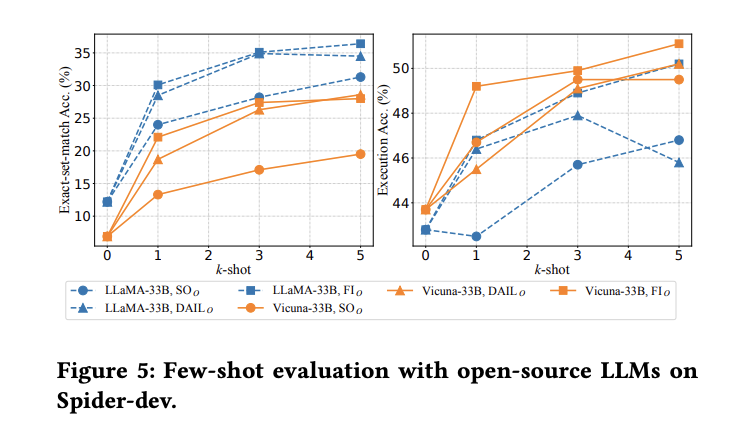
[Source here](https://arxiv.org/pdf/2308.15363.pdf)